In [1]:
%run packages_imported.py
%run EDA.py

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle


In [3]:
#df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')

In [20]:
frame1 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'entertainment'][:1000]
frame2 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'financial'][:1000]
frame3 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'political'][:1000]
frame4 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'sport'][:1000]
frame5 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'technology'][:1000]
frame6 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'world'][:1000]
frame7 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel'][:1000]

frames = [frame1, frame2, frame3, frame4, frame5, frame6, frame7]
df_processed_smaller = pd.concat(frames)
df_processed_smaller.reset_index()
df_processed_smaller.to_pickle('data/original_data/pickles/df_processed_smaller_before_tuning')

--------

In [6]:
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_before_tuning')

X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

In [3]:
t1 = time.time() 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(min_df=0.1, max_df=0.9)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 2 seconds


In [126]:
from sklearn.model_selection import GridSearchCV

In [114]:
t1 = time.time() 

y = df_all_news_processed['Category']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

r_f_c = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, random_state=0)
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'log2']
}
CV_rfc = GridSearchCV(estimator=r_f_c, param_grid=param_grid, cv= 5)

CV_rfc.fit(X_train, y_train) 
print (CV_rfc.best_params_)
EDA.process_time(round(time.time()-t1))

{'max_features': 'log2', 'n_estimators': 700}
Process completed.
Time taken: 2mins 11secs


For tuning: https://towardsdatascience.com/tuning-parameters-heres-how-39a4d1956f79

## Naive Bayes (Multinomial?)

In [344]:
from sklearn.naive_bayes import MultinomialNB
algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__norm': ('l1', 'l2'),
    'clf__fit_prior': [True, False],
    'clf__alpha': [1, 0.6, 0.1, 1e-2, 1e-3, 1e-4]
}

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [345]:
t1 = time.time() 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

clf = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

print(classification_report(Y_test, y_pred, digits=4))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7419    0.7931    0.7667       203
    financial     0.7034    0.7411    0.7217       224
    political     0.6125    0.5506    0.5799       178
        sport     0.8242    0.6977    0.7557       215
   technology     0.5614    0.6995    0.6229       183
       travel     0.7500    0.7258    0.7377       186
        world     0.6345    0.5924    0.6127       211

     accuracy                         0.6879      1400
    macro avg     0.6897    0.6857    0.6853      1400
 weighted avg     0.6932    0.6879    0.6882      1400

Best Score:  0.7008928571428571
Best Params:  {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Process completed.
Time taken: 4h 41mins 10secs


#### Confusion Matrix

In [ ]:
EDA.display_confusion_matrix(y_test, clf.predict(X_test), distinct_categories, plot_title="Multinomial Naive Bayes Confusion Matrix")

In [349]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/mnb_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/mnb_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

## Linear classifiers wwith SGD training

In [98]:
from sklearn.linear_model import SGDClassifier
t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('sgd', SGDClassifier())])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

'''

('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))]
sdg.fit(X_train, Y_train)
y_pred = sdg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=distinct_categories))
EDA.process_time(round(time.time()-t1))'''

tuned_parameters = {
    'sgd__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'sgd__loss': ['hinge', "log", "modified_huber", "perceptron", "squared_hinge"],
    'sgd__penalty': ['l1', 'l2'],
    'sgd__random_state': [42],
    'sgd__n_iter_no_change': [30],
    'sgd__tol': [None],
    'sgd__n_jobs': [-1]
}


sgd = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
sgd.fit(x_train, y_train)

y_pred = sgd.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", sgd.best_score_)
print("Best Params: ", sgd.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7364    0.7980    0.7660       203
    financial     0.7535    0.7232    0.7380       224
    political     0.5829    0.6124    0.5973       178
        sport     0.7682    0.7860    0.7770       215
   technology     0.5991    0.6940    0.6430       183
       travel     0.7798    0.7043    0.7401       186
        world     0.6798    0.5735    0.6221       211

     accuracy                         0.7007      1400
    macro avg     0.6999    0.6988    0.6976      1400
 weighted avg     0.7038    0.7007    0.7006      1400

Best Score:  0.7160714285714286
Best Params:  {'sgd__alpha': 0.001, 'sgd__loss': 'modified_huber', 'sgd__n_iter_no_change': 30, 'sgd__n_jobs': -1, 'sgd__penalty': 'l2', 'sgd__random_state': 42, 'sgd__tol': None}
Process completed.
Time taken: 1h 53mins 53secs


In [124]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(sgd, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

#### Display Accuracy scores

In [358]:
x_values=list(sgd.cv_results_['param_sgd__alpha'])
x_label="Alpha values"

y_label="Accuracy scores"
y_values= list(sgd.cv_results_['mean_test_score'])
title="SDG Best Alpha Scores based on their Accuracy (select an area to zoom in)"
EDA.display_accuracy_scores_per_parameter(x_values, y_values, x_label, y_label, title)


#### Confusion Matrix

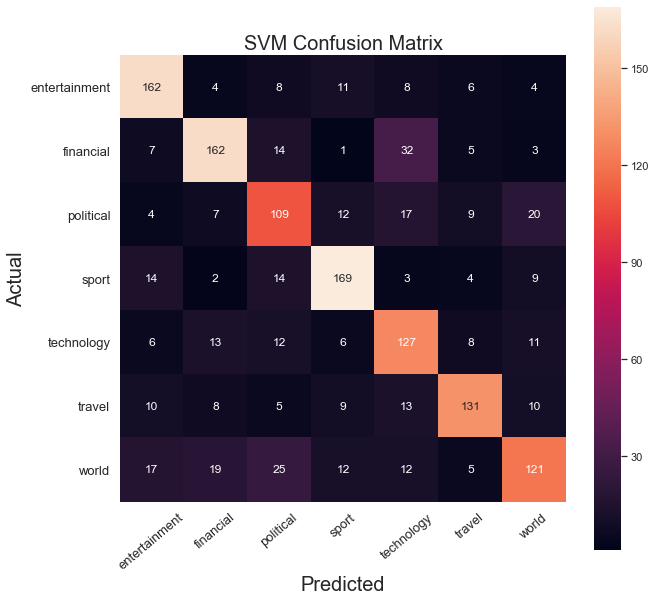

In [337]:
#plot_title = "SVM Confusion Matrix"
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix")

## Random Forest

In [ ]:
#https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn
#https://stackoverflow.com/questions/48554577/hyperparameter-tuning-random-forest-classifier-with-gridsearchcv-based-on-probab
#https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

t1 = time.time() 

algo_pipe = Pipeline([('vectorizer',CountVectorizer()),
                     ('rfc', RandomForestClassifier(n_jobs=-1))])

'''algo_pipe = Pipeline([("scaler", StandardScaler()),
                     ('rfc', RandomForestClassifier(n_jobs=-1))])'''

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

'''tuned_parameters = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': [100, 300, 500],
    'rfc__max_features': ['auto', 'log2', 'sqrt', 0.73, 0.80],
    'rfc__bootstrap': [True, False],
    'rfc__min_samples_split': [3, 5, 7]
}
'''
tuned_parameters = {
    'rfc__max_features': ['auto', 'log2', 'sqrt', 0.60, 0.73, 0.85],
    'rfc__criterion': ['gini', 'entropy'],
    #'rfc__n_estimators': [50, 100, 300],
    'rfc__bootstrap': [True, False],
    'rfc__min_samples_split': [3, 5, 10, 20]
}

rfc = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", rfc.best_score_)
print("Best Params: ", rfc.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7143    0.7143    0.7143       203
    financial     0.6486    0.6429    0.6457       224
    political     0.4783    0.6180    0.5392       178
        sport     0.7667    0.7488    0.7576       215
   technology     0.5337    0.5628    0.5479       183
       travel     0.6687    0.5860    0.6246       186
        world     0.5810    0.4929    0.5333       211

     accuracy                         0.6257      1400
    macro avg     0.6273    0.6237    0.6232      1400
 weighted avg     0.6321    0.6257    0.6268      1400

Best Score:  0.6205357142857143
Best Params:  {'rfc__bootstrap': False, 'rfc__criterion': 'gini', 'rfc__max_features': 'sqrt', 'rfc__min_samples_split': 20}
Process completed.
Time taken: 1h 27mins 20secs


In [ ]:
'''

Best Score:  0.5885714285714285
Best Params:  {'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_features': 0.6, 'rfc__min_samples_split': 5}
'''

In [9]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/rfc_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(rfc, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

"# reload the object\nwith open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:\n    grid_reloaded = pickle.load(handle)"

## XGBoost

In [ ]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

t1 = time.time() 

algo_pipe = Pipeline([('vect', CountVectorizer()),
                     ('xgb', XGBClassifier(n_jobs=-1))])


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#https://xgboost.readthedocs.io/en/latest/parameter.html
tuned_parameters = {
    'xgb__learning_rate': [0.01, 0.2],
    'xgb__gamma': [0.1],
    'xgb__booster': ['gbtree'],
    'xgb__max_depth': [2, 3, 4, 5],
    'xgb__subsample': [0.5, 0.75, 1],
    'xgb__colsample_bytree': [0.8, 0.9],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__verbosity': [0] #this is to hide the warnings
}

xgb = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", xgb.best_score_)
print("Best Params: ", xgb.best_params_)
EDA.process_time(round(time.time()-t1))

In [ ]:
'''
Best Score:  0.6969642857142857
Best Params:  {'xgb__booster': 'gbtree', 'xgb__colsample_bytree': 0.9, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__verbosity': 0}
'''

In [52]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/xgb_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

"# reload the object\nwith open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:\n    grid_reloaded = pickle.load(handle)"

## Logistic Regression

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lrgr', LogisticRegression(n_jobs=-1))])


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

#https://xgboost.readthedocs.io/en/latest/parameter.html
tuned_parameters = {
    'lrgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lrgr__penalty': ['l1', 'l2'],
    'lrgr__max_iter': [50, 100, 200, 500, 1000],
    'lrgr__random_state': [42],
}

lrgr = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
lrgr.fit(x_train, y_train)

y_pred = lrgr.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", lrgr.best_score_)
print("Best Params: ", lrgr.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7364    0.7980    0.7660       203
    financial     0.7689    0.7277    0.7477       224
    political     0.5591    0.5843    0.5714       178
        sport     0.7767    0.7767    0.7767       215
   technology     0.6085    0.7049    0.6532       183
       travel     0.7857    0.7097    0.7458       186
        world     0.6578    0.5829    0.6181       211

     accuracy                         0.7000      1400
    macro avg     0.6990    0.6978    0.6970      1400
 weighted avg     0.7032    0.7000    0.7002      1400

Best Score:  0.7126785714285714
Best Params:  {'lrgr__C': 10, 'lrgr__max_iter': 50, 'lrgr__penalty': 'l2', 'lrgr__random_state': 42}
Process completed.
Time taken: 29mins 1secs


In [13]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/lrgr_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(lrgr, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

"# reload the object\nwith open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:\n    grid_reloaded = pickle.load(handle)"

## Passive-Aggressive

In [17]:
from sklearn.linear_model import PassiveAggressiveClassifier 
algo_pipe = Pipeline([('count', CountVectorizer()),
                     ('pasagr', PassiveAggressiveClassifier())])
t1 = time.time() 

tuned_parameters = {
    'pasagr__C': [0.35, 0.42, 0.5, 0.65, 0.75],
    'pasagr__n_iter_no_change': [5, 8, 12, 20, 50, 100],
    'pasagr__random_state': [42]
}

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

pasagr = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
pasagr.fit(x_train, y_train)

y_pred = pasagr.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", pasagr.best_score_)
print("Best Params: ", pasagr.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7184    0.7291    0.7237       203
    financial     0.7236    0.6429    0.6809       224
    political     0.4789    0.5730    0.5217       178
        sport     0.7357    0.7767    0.7557       215
   technology     0.5968    0.6066    0.6016       183
       travel     0.7362    0.6452    0.6877       186
        world     0.5922    0.5782    0.5851       211

     accuracy                         0.6529      1400
    macro avg     0.6545    0.6502    0.6509      1400
 weighted avg     0.6589    0.6529    0.6544      1400

Best Score:  0.6575
Best Params:  {'pasagr__C': 0.35, 'pasagr__n_iter_no_change': 100, 'pasagr__random_state': 42}
Process completed.
Time taken: 11mins 12secs


## SVC

In [29]:
from sklearn.svm import SVC
t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC())])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

tuned_parameters = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", svc.best_score_)
print("Best Params: ", svc.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7455    0.8079    0.7754       203
    financial     0.7729    0.7143    0.7425       224
    political     0.5495    0.6236    0.5842       178
        sport     0.8200    0.7628    0.7904       215
   technology     0.5953    0.6995    0.6432       183
       travel     0.8012    0.6935    0.7435       186
        world     0.6462    0.5972    0.6207       211

     accuracy                         0.7014      1400
    macro avg     0.7044    0.6998    0.7000      1400
 weighted avg     0.7092    0.7014    0.7033      1400

Best Score:  0.7173214285714286
Best Params:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}
Process completed.
Time taken: 8h 40mins 25secs


In [20]:
##### aggelos
from sklearn.svm import SVC
t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC())])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)



tuned_parameters = {
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.9],
    'svc__C': [10],
    'svc__gamma': [0.1],
    #'svc__kernel': ['linear', 'poly', 'sigmoid']
    'svc__kernel': ['sigmoid']
}

svc = GridSearchCV(algo_pipe, tuned_parameters, scoring='accuracy')
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", svc.best_score_)
print("Best Params: ", svc.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7674    0.8128    0.7895       203
    financial     0.7656    0.7143    0.7390       224
    political     0.5256    0.6348    0.5751       178
        sport     0.8284    0.7860    0.8067       215
   technology     0.5981    0.6831    0.6378       183
       travel     0.8247    0.6828    0.7471       186
        world     0.6649    0.6114    0.6370       211

     accuracy                         0.7057      1400
    macro avg     0.7107    0.7036    0.7046      1400
 weighted avg     0.7158    0.7057    0.7083      1400

Best Score:  0.7051785714285714
Best Params:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid', 'tfidf__max_df': 0.9, 'tfidf__min_df': 0.001}
Process completed.
Time taken: 2mins 8secs


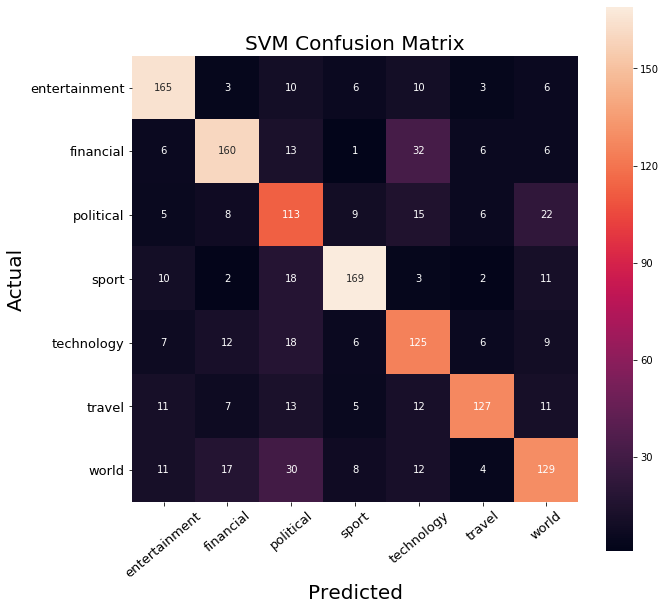

In [21]:
EDA.display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVC Confusion Matrix")

In [30]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/svc_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(svc, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

"# reload the object\nwith open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:\n    grid_reloaded = pickle.load(handle)"

# Summary of algorithms

In [ ]:
#to do:
#1) to add the visuals for every algo compared to accuracy *
#2) write the summary of the algorithms and the best chosen

# *ref: https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2

In [29]:
grid_reloaded.cv_results_['mean_test_score']

array([0.69142857, 0.70392857, 0.68392857, 0.71410714, 0.66946429,
       0.70232143, 0.50625   , 0.56803571, 0.56803571, 0.63857143,
       0.50285714, 0.70142857, 0.54678571, 0.69821429, 0.64767857,
       0.71607143, 0.23428571, 0.55428571, 0.64642857, 0.71607143,
       0.14267857, 0.69589286, 0.14607143, 0.6675    , 0.29785714,
       0.70142857, 0.14214286, 0.55125   , 0.29767857, 0.70142857,
       0.14464286, 0.54089286, 0.14464286, 0.33446429, 0.14553571,
       0.65821429, 0.14267857, 0.54160714, 0.14553571, 0.65821429,
       0.14267857, 0.19482143, 0.14267857, 0.19785714, 0.14267857,
       0.23017857, 0.14178571, 0.48571429, 0.14267857, 0.23017857])

In [30]:
grid_reloaded.best_score_

0.7160714285714286

### Keras

<p style="color:red;">MemoryError:</p> <i>Unable to allocate 31.3 GiB for an array with shape (3733, 1125750) and data type float64</i>


Notes for an interesting approach on keras
https://www.kdnuggets.com/2018/11/multi-class-text-classification-model-comparison-selection.html/2

### Models comparison

In [22]:
#visualise here